## Define a class to deal with the results

In [2]:
class TRIDYN_simulation:
    def __init__(self, file_retained = "", file_profiles = "",aantalincomming = 1,fractions = [1],elementen = []):
        self.file_retained = file_retained
        self.file_profiles = file_profiles
        self.fluence_vals = 0
        self.retained_vals = 0
        self.retained_calc = 0
        self.depth_vals = 0
        self.concentration_vals_implanted = 0
        self.concentration_vals_substrate = 0
        self.surface_density = 0
        self.aantalincomming = aantalincomming
        self.fractions = fractions
        self.elementen = elementen        
        
    def print_filenames(self):
        if (self.file_retained != ""):
            print("retained amount is located at " + self.file_retained + "\n")
        if (self.file_profiles != ""):
            print("Depth profiles is located at " + self.file_profiles + "\n")
            
            
    def load_retained(self):
        if (self.file_retained != ""):
            with open(self.file_retained) as f:
                lines = f.readlines()
            tebekijk = (lines[-1])
            counter = 0
            colspecs = []
            tuple1 = 0
            tuple2 = 0
            inwoord = False
            for ii in tebekijk:
                if not ii.isspace():
                    if not inwoord:
                        inwoord = True
                        tuple1 = counter
                else: #wel een spatie
                    if inwoord == True: #je zat in een woord en dus is het einde bereikt
                        tuple2 = counter
                        inwoord = False
                if tuple1!=0 and tuple2!=0:
                    colspecs.append((tuple1,tuple2))
                    tuple1 = 0
                    tuple2 = 0        
                counter+=1
            #print(colspecs)      

            simulation = np.array(pd.read_fwf(self.file_retained, colspecs=colspecs, header=1).T) #areal density
            self.fluence_vals = simulation[0]
            self.retained_vals = []
            for ii in range(self.aantalincomming):
                self.retained_vals.append(simulation[2+ii])
        else:
            print("No ardn file selected")
            self.fluence_vals = np.zeros(100)
            self.retained_vals = np.zeros(100)
      
    
    def load_profiles(self):
        if (self.file_profiles != ""):        
            ls_files = os.listdir(path=self.file_profiles)
            
            dirfile = path + profiles + ls_files[0]
            with open(dirfile) as f:
                lines = f.readlines()
            tebekijk = (lines[-1])
            counter = 0
            colspecs = []
            tuple1 = 0
            tuple2 = 0
            inwoord = False
            for ii in tebekijk:
                if not ii.isspace():
                    if not inwoord:
                        inwoord = True
                        tuple1 = counter
                else: #wel een spatie
                    if inwoord == True: #je zat in een woord en dus is het einde bereikt
                        tuple2 = counter
                        inwoord = False
                if tuple1!=0 and tuple2!=0:
                    colspecs.append((tuple1,tuple2))
                    tuple1 = 0
                    tuple2 = 0        
                counter+=1
            #print(colspecs)
                        
            self.depth_vals = []
            self.surface_density = []
            self.concentration_vals_substrate = []
            self.concentration_vals_implanted = []
            
            
            for i in range(len(ls_files)):
                directory_file = self.file_profiles + ls_files[i]
                
                single_profile = np.array(pd.read_fwf(directory_file, colspecs = colspecs, header=4).T)
                
                for i in range(len(single_profile[2])):
                    for jj in range(self.aantalincomming+1):
                        single_profile[jj+2][i] = np.float64(str(single_profile[jj+2][i]).rstrip("-").lstrip("-"))
                        #single_profile[2][i] = np.float64(str(single_profile[2][i]).rstrip("-").lstrip("-"))
                        #single_profile[3][i] = np.float64(str(single_profile[3][i]).rstrip("-").lstrip("-"))
                
                #print(single_profile[2])
                
                self.depth_vals.append(single_profile[0])
                self.surface_density.append(single_profile[1])
                self.concentration_vals_substrate.append(single_profile[2])
                toetevoegen = []
                for jj in range(self.aantalincomming):
                    toetevoegen.append(single_profile[jj+3])
                self.concentration_vals_implanted.append(toetevoegen)
        
        else:
            print("No depth profile files selected")
            self.depth_vals = np.zeros((100, 100))
            self.surface_density = np.zeros((100, 100))
            self.concentration_vals_substrate = np.zeros((100, 100))
            self.concentration_vals_implanted = np.zeros((100, 100))
        
        
    def calc_retained(self, start_depth=0, end_depth=10**6):
        del_depth = self.depth_vals[0][1] - self.depth_vals[0][0]
        max_depth = self.depth_vals[0][-1] + del_depth/2
        self.retained_calc = []
        for ii in range(self.aantalincomming):
            self.retained_calc.append(np.zeros(len(self.retained_vals[0])))
        self.retained_calc = np.array(self.retained_calc)
        
        for i in range(len(self.depth_vals)):  #0 tot 100          
            acc = np.zeros(self.aantalincomming)
            
            for j in range(len(self.depth_vals[0])): #0 tot diepte   
                if ((self.depth_vals[0][j] > start_depth) and (self.depth_vals[0][j] < end_depth)):
                    #print((self.concentration_vals_implanted)[i])
                    for jj in range(self.aantalincomming):
                        acc[jj] += del_depth * np.array(self.concentration_vals_implanted)[i][jj][j] * self.surface_density[i][j]
            
            self.retained_calc[:,i] = acc        
        
        
    def load(self):
        self.load_retained()
        self.load_profiles()
    
    
    def draw_retained(self, **kwargs):
        for jj in range(self.aantalincomming):
            plt.plot(self.fluence_vals*self.fractions[jj], self.retained_vals[jj])
        plt.xlabel("Implantation fluence scaled for the fraction ($\AA ^{-2}$)")
        plt.ylabel("Retained fluence ($\AA ^{-2}$)")
        plt.legend(self.elementen)
        plt.grid()
        
    def draw_retained_Tb(self, **kwargs):
        jj=0
        plt.plot(self.fluence_vals*self.fractions[jj], self.retained_vals[jj])
        plt.xlabel("Implantation fluence scaled for the fraction ($\AA ^{-2}$)")
        plt.ylabel("Retained fluence for Tb ($\AA ^{-2}$)")
        plt.grid()
        
        
    def draw_lost(self, **kwargs):
        for jj in range(self.aantalincomming):
            plt.plot(self.fluence_vals*self.fractions[jj], self.fluence_vals*self.fractions[jj] - self.retained_vals[jj])
        plt.xlabel("Implantation fluence scaled for the fraction ($\AA ^{-2}$)")
        plt.ylabel("Lost fluence ($\AA ^{-2}$)")
        plt.legend(self.elementen)
        plt.grid()
        
    
    def draw_calc_retained(self, **kwargs):
        for jj in range(self.aantalincomming):
            plt.plot(self.fluence_vals*self.fractions[jj], np.array(self.retained_calc)[jj], "--")
        plt.xlabel("Implantation fluence scaled for the fraction ($\AA ^{-2}$)")
        plt.ylabel("Retained fluence ($\AA ^{-2}$)")
        plt.legend(self.elementen)
        plt.grid()
        
        
    def draw_profile(self, index, bool_implant, **kwargs):
        if bool_implant:
            for jj in range(self.aantalincomming):
                plt.plot(self.depth_vals[index], self.concentration_vals_implanted[index][jj])
            plt.legend(self.elementen)
        else:
            plt.plot(self.depth_vals[index], self.concentration_vals_substrate[index])
        
        plt.xlabel("Depth ($\AA$)")
        plt.ylabel("Concentration (%)")
        plt.grid()
        
        
    def draw_3d(self, **kwargs):
        X = self.depth_vals[0]
        Y = self.fluence_vals
        for jj in range(self.aantalincomming):
            print(jj)
            Y = self.fluence_vals*self.fractions[jj]
            K, L = np.meshgrid(X, Y)
            Z = np.array(self.concentration_vals_implanted)[:,jj]
            im = pyl.pcolormesh(K, L, Z, shading='auto')
            cbar = plt.colorbar(im,orientation='vertical')
            plt.xlabel("Depth ($\AA$)")
            plt.ylabel("Fluence ($\AA ^{-2}$)")
            plt.title(self.elementen[jj])
            cbar.set_label("Atomic concentration (%)")
            plt.show()
        

In [10]:
allnames = ['TbfGd_0_00.in',
 'TbfGd_1_00.in',
 'TbfGd_2_00.in',
 'TbfGd_3_00.in',
 'TbfGd_4_00.in',
 'TbfGd_5_00.in',
 'TbfGd_6_00.in',
 'TbfGd_7_00.in',
 'TbfGd_8_00.in',
 'TbfGd_9_00.in',
 'TbfGd_0_03.in',
 'TbfGd_1_03.in',
 'TbfGd_2_03.in',
 'TbfGd_3_03.in',
 'TbfGd_4_03.in',
 'TbfGd_5_03.in',
 'TbfGd_6_03.in',
 'TbfGd_7_03.in',
 'TbfGd_8_03.in',
 'TbfGd_9_03.in',
 'TbfGd_0_05.in',
 'TbfGd_1_05.in',
 'TbfGd_2_05.in',
 'TbfGd_3_05.in',
 'TbfGd_4_05.in',
 'TbfGd_5_05.in',
 'TbfGd_6_05.in',
 'TbfGd_7_05.in',
 'TbfGd_8_05.in',
 'TbfGd_9_05.in',
 'TbfGd_0_08.in',
 'TbfGd_1_08.in',
 'TbfGd_2_08.in',
 'TbfGd_3_08.in',
 'TbfGd_4_08.in',
 'TbfGd_5_08.in',
 'TbfGd_6_08.in',
 'TbfGd_7_08.in',
 'TbfGd_8_08.in',
 'TbfGd_9_08.in',
 'TbfGd_0_11.in',
 'TbfGd_1_11.in',
 'TbfGd_2_11.in',
 'TbfGd_3_11.in',
 'TbfGd_4_11.in',
 'TbfGd_5_11.in',
 'TbfGd_6_11.in',
 'TbfGd_7_11.in',
 'TbfGd_8_11.in',
 'TbfGd_9_11.in',
 'TbfGd_0_13.in',
 'TbfGd_1_13.in',
 'TbfGd_2_13.in',
 'TbfGd_3_13.in',
 'TbfGd_4_13.in',
 'TbfGd_5_13.in',
 'TbfGd_6_13.in',
 'TbfGd_7_13.in',
 'TbfGd_8_13.in',
 'TbfGd_9_13.in',
 'TbfGd_0_16.in',
 'TbfGd_1_16.in',
 'TbfGd_2_16.in',
 'TbfGd_3_16.in',
 'TbfGd_4_16.in',
 'TbfGd_5_16.in',
 'TbfGd_6_16.in',
 'TbfGd_7_16.in',
 'TbfGd_8_16.in',
 'TbfGd_9_16.in',
 'TbfGd_0_18.in',
 'TbfGd_1_18.in',
 'TbfGd_2_18.in',
 'TbfGd_3_18.in',
 'TbfGd_4_18.in',
 'TbfGd_5_18.in',
 'TbfGd_6_18.in',
 'TbfGd_7_18.in',
 'TbfGd_8_18.in',
 'TbfGd_9_18.in',
 'TbfGd_0_21.in',
 'TbfGd_1_21.in',
 'TbfGd_2_21.in',
 'TbfGd_3_21.in',
 'TbfGd_4_21.in',
 'TbfGd_5_21.in',
 'TbfGd_6_21.in',
 'TbfGd_7_21.in',
 'TbfGd_8_21.in',
 'TbfGd_9_21.in',
 'TbfGd_0_24.in',
 'TbfGd_1_24.in',
 'TbfGd_2_24.in',
 'TbfGd_3_24.in',
 'TbfGd_4_24.in',
 'TbfGd_5_24.in',
 'TbfGd_6_24.in',
 'TbfGd_7_24.in',
 'TbfGd_8_24.in',
 'TbfGd_9_24.in',
 'TbfGd_0_26.in',
 'TbfGd_1_26.in',
 'TbfGd_2_26.in',
 'TbfGd_3_26.in',
 'TbfGd_4_26.in',
 'TbfGd_5_26.in',
 'TbfGd_6_26.in',
 'TbfGd_7_26.in',
 'TbfGd_8_26.in',
 'TbfGd_9_26.in',
 'TbfGd_0_29.in',
 'TbfGd_1_29.in',
 'TbfGd_2_29.in',
 'TbfGd_3_29.in',
 'TbfGd_4_29.in',
 'TbfGd_5_29.in',
 'TbfGd_6_29.in',
 'TbfGd_7_29.in',
 'TbfGd_8_29.in',
 'TbfGd_9_29.in',
 'TbfGd_0_32.in',
 'TbfGd_1_32.in',
 'TbfGd_2_32.in',
 'TbfGd_3_32.in',
 'TbfGd_4_32.in',
 'TbfGd_5_32.in',
 'TbfGd_6_32.in',
 'TbfGd_7_32.in',
 'TbfGd_8_32.in',
 'TbfGd_9_32.in',
 'TbfGd_0_34.in',
 'TbfGd_1_34.in',
 'TbfGd_2_34.in',
 'TbfGd_3_34.in',
 'TbfGd_4_34.in',
 'TbfGd_5_34.in',
 'TbfGd_6_34.in',
 'TbfGd_7_34.in',
 'TbfGd_8_34.in',
 'TbfGd_9_34.in',
 'TbfGd_0_37.in',
 'TbfGd_1_37.in',
 'TbfGd_2_37.in',
 'TbfGd_3_37.in',
 'TbfGd_4_37.in',
 'TbfGd_5_37.in',
 'TbfGd_6_37.in',
 'TbfGd_7_37.in',
 'TbfGd_8_37.in',
 'TbfGd_9_37.in',
 'TbfGd_0_39.in',
 'TbfGd_1_39.in',
 'TbfGd_2_39.in',
 'TbfGd_3_39.in',
 'TbfGd_4_39.in',
 'TbfGd_5_39.in',
 'TbfGd_6_39.in',
 'TbfGd_7_39.in',
 'TbfGd_8_39.in',
 'TbfGd_9_39.in',
 'TbfGd_0_42.in',
 'TbfGd_1_42.in',
 'TbfGd_2_42.in',
 'TbfGd_3_42.in',
 'TbfGd_4_42.in',
 'TbfGd_5_42.in',
 'TbfGd_6_42.in',
 'TbfGd_7_42.in',
 'TbfGd_8_42.in',
 'TbfGd_9_42.in',
 'TbfGd_0_45.in',
 'TbfGd_1_45.in',
 'TbfGd_2_45.in',
 'TbfGd_3_45.in',
 'TbfGd_4_45.in',
 'TbfGd_5_45.in',
 'TbfGd_6_45.in',
 'TbfGd_7_45.in',
 'TbfGd_8_45.in',
 'TbfGd_9_45.in',
 'TbfGd_0_47.in',
 'TbfGd_1_47.in',
 'TbfGd_2_47.in',
 'TbfGd_3_47.in',
 'TbfGd_4_47.in',
 'TbfGd_5_47.in',
 'TbfGd_6_47.in',
 'TbfGd_7_47.in',
 'TbfGd_8_47.in',
 'TbfGd_9_47.in',
 'TbfGd_0_50.in',
 'TbfGd_1_50.in',
 'TbfGd_2_50.in',
 'TbfGd_3_50.in',
 'TbfGd_4_50.in',
 'TbfGd_5_50.in',
 'TbfGd_6_50.in',
 'TbfGd_7_50.in',
 'TbfGd_8_50.in',
 'TbfGd_9_50.in']

['TbfGd_0_00.in', 'TbfGd_1_00.in', 'TbfGd_2_00.in', 'TbfGd_3_00.in', 'TbfGd_4_00.in', 'TbfGd_5_00.in', 'TbfGd_6_00.in', 'TbfGd_7_00.in', 'TbfGd_8_00.in', 'TbfGd_9_00.in']
For fraction of Tb = 0.001 the retained fluence for an incoming fluence of 1, is 0.000557143 (up: 0.00071429, down: 0.00028571
For fraction of Tb = 0.001 the retained activity for an incoming activity of 30.159289473402964, is 16.803037015080147 (up: 21.54247887795699, down: 8.61681059544596
['TbfGd_0_03.in', 'TbfGd_1_03.in', 'TbfGd_2_03.in', 'TbfGd_3_03.in', 'TbfGd_4_03.in', 'TbfGd_5_03.in', 'TbfGd_6_03.in', 'TbfGd_7_03.in', 'TbfGd_8_03.in', 'TbfGd_9_03.in']
For fraction of Tb = 0.02726316 the retained fluence for an incoming fluence of 1, is 0.0177427 (up: 0.018571, down: 0.016571
For fraction of Tb = 0.02726316 the retained activity for an incoming activity of 822.2375343997008, is 535.1072253397467 (up: 560.0881648105662, down: 499.7695858637608
['TbfGd_0_05.in', 'TbfGd_1_05.in', 'TbfGd_2_05.in', 'TbfGd_3_05.in', 

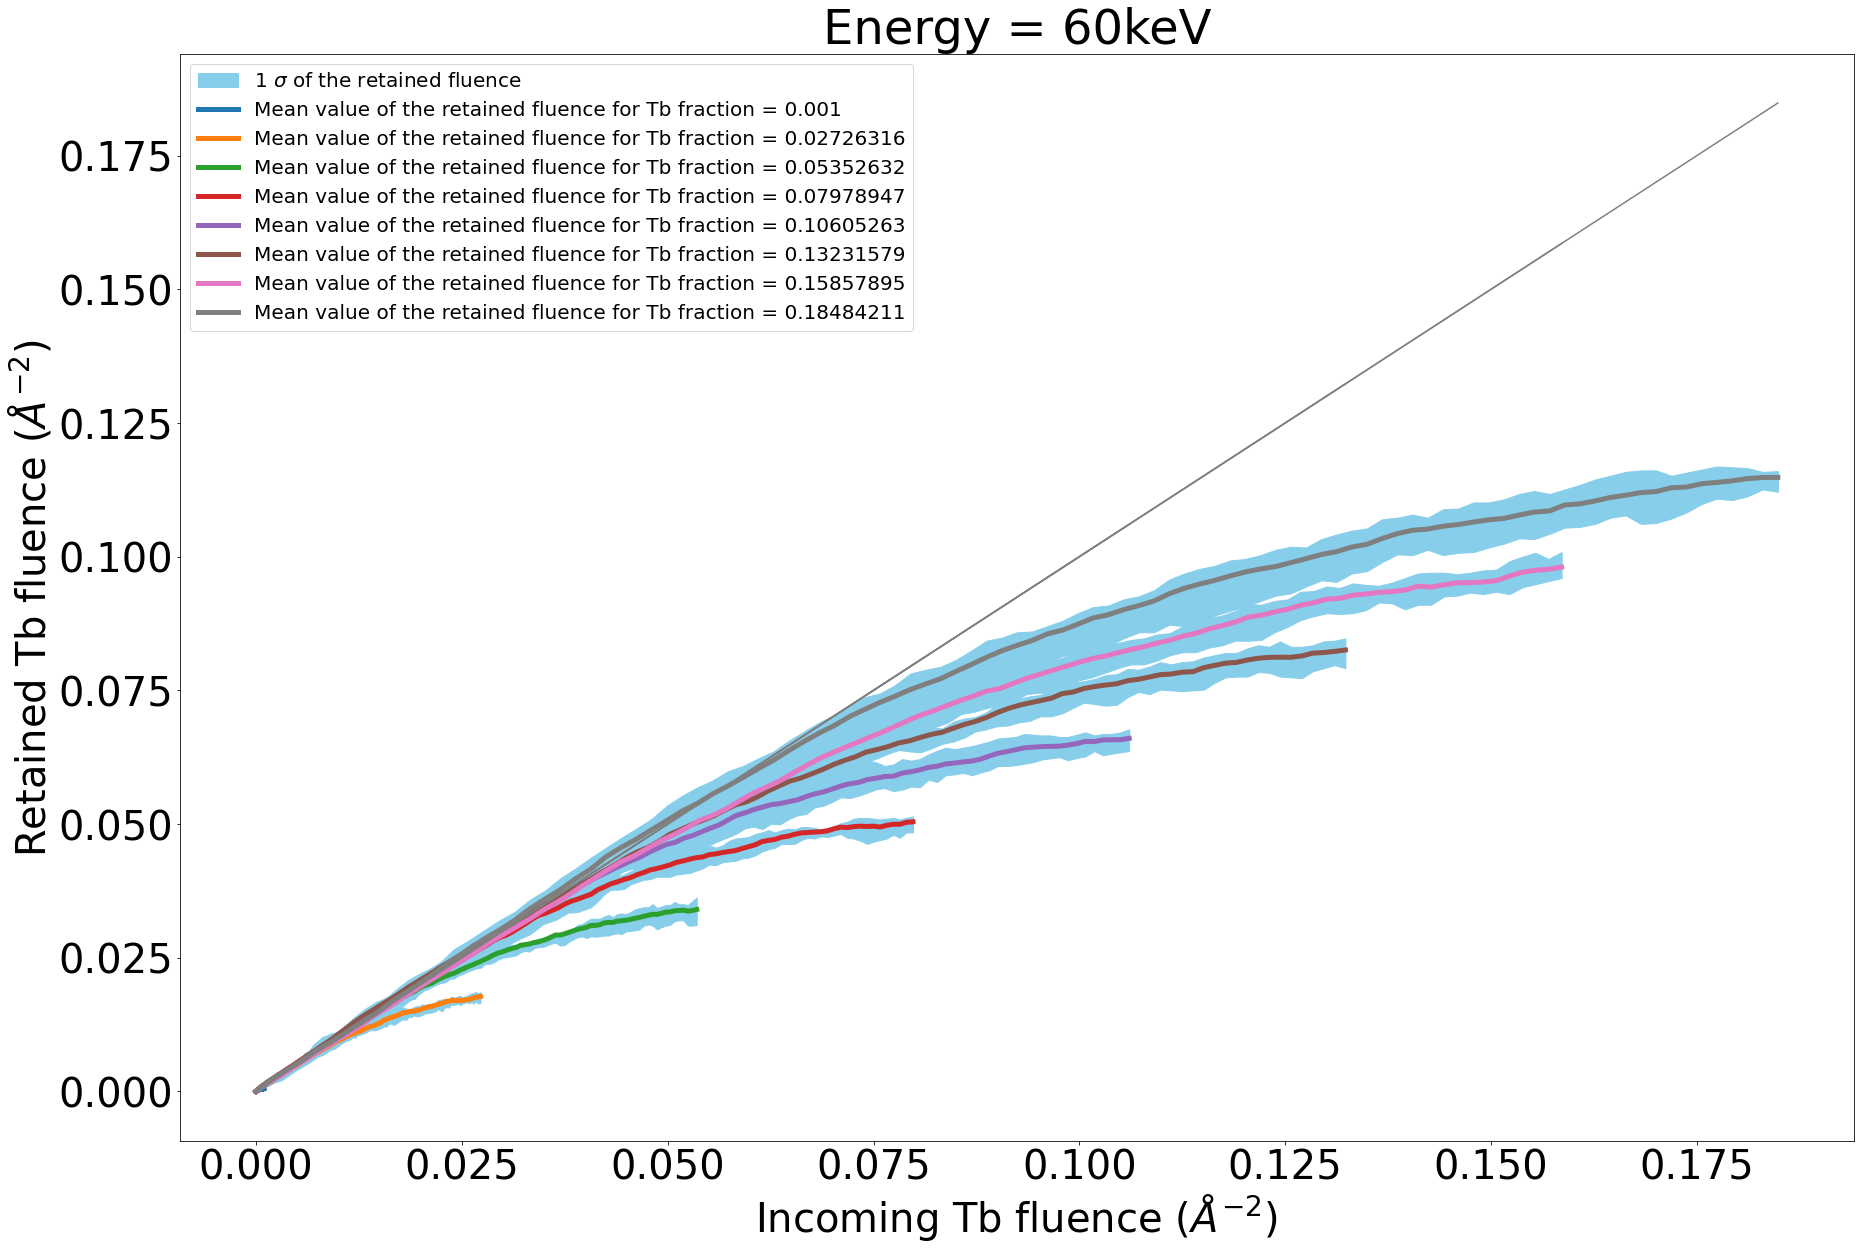

In [12]:
plt.rcParams.update({'font.size': 40})
plt.figure(figsize=(30, 20))
plt.tight_layout()
fractions = np.linspace(0.001,0.5,20)
fractions = [0.001,0.02726316,0.05352632,0.07978947,0.10605263,0.13231579,0.15857895,0.18484211]
counter = 0
for fraction in fractions:
    finalretfl = []
    finalretflup = []
    finalretfldown = []
    namenlijst = allnames[counter*10:counter*10+10]
    print(namenlijst)
    retainedcurves=[]
    for nametje in namenlijst:
        name = nametje[0:len(nametje)-3]
        path = "C:/Users/r0750853/linux/TRIDYN/Simulated_data/Effect_of_fractionGd_Tb/"
        areal_dens = "Areal_density/" + name + "_ardn.dat"
        profiles = "Depth_profile/" + name + "/"
        A = TRIDYN_simulation(file_retained = path + areal_dens, file_profiles = path + profiles, aantalincomming = 2, fractions = [fraction,1-fraction],elementen=['Tb','Gd'])
        A.load()
        retainedcurves.append(np.array(A.retained_vals[0]))
    retainedcurves = np.array(retainedcurves) #consist of the retained curves for each of the 10 random numbers
    means = []
    stdevup = []
    stdevdown = []
    sigmapos = []
    influ = A.fluence_vals
    startsputtt=[]
    for ii in range(101):
        retwaarden = retainedcurves[:,ii]
        means.append(np.mean(retwaarden))
        gesort  = np.sort(retwaarden)
        #print(gesort)
        stdevdown.append(gesort[1])
        stdevup.append(gesort[7])
        sigmapos.append(np.std(retwaarden))
    if counter==0:
        plt.fill_between(influ*fraction,stdevdown,stdevup,color = 'skyblue',label='1 $\sigma$ of the retained fluence')
    else:
        plt.fill_between(influ*fraction,stdevdown,stdevup,color = 'skyblue')
    plt.plot(influ*fraction,means,lw=5,label='Mean value of the retained fluence for Tb fraction = '+str(fraction))
    plt.plot(np.linspace(0,1*fraction,10),np.linspace(0,1*fraction,10),'gray')
    plt.ylabel('Retained Tb fluence ($\AA^{-2}$)')
    plt.xlabel('Incoming Tb fluence ($\AA^{-2}$)')
    plt.title('Energy = 60keV')
    finalretfl.append(means[-1])
    finalretflup.append(stdevup[-1])
    finalretfldown.append(stdevdown[-1])
    print('For fraction of Tb = ' +str(fraction)+ ' the retained fluence for an incoming fluence of 1, is ' + str(means[-1]) +' (up: ' + str(stdevup[-1])+ ', down: '+ str(stdevdown[-1]))
    deltar=0.000005#in mm
    retjes = np.array(np.arange(0,8,deltar))
    #incoming activity
    partinc = 1*(np.pi*((retjes+deltar)**2-(retjes)**2)*10**(14))
    totpartinc = np.sum(partinc)*fraction
    actinc = totpartinc*1.5*10**(-6)*10**(-6)
    #mean activity
    partret = finalretfl*(np.pi*((retjes+deltar)**2-(retjes)**2)*10**(14))
    totpartret = np.sum(partret)
    actcollected = totpartret*1.5*10**(-6)*10**(-6)
    #upact
    partretup = finalretflup*(np.pi*((retjes+deltar)**2-(retjes)**2)*10**(14))
    totpartup = np.sum(partretup)
    actup = totpartup*1.5*10**(-6)*10**(-6)
    #downact
    partretdown= finalretfldown*(np.pi*((retjes+deltar)**2-(retjes)**2)*10**(14))
    totpartdown = np.sum(partretdown)
    actdown = totpartdown*1.5*10**(-6)*10**(-6)
    print('For fraction of Tb = ' +str(fraction)+ ' the retained activity for an incoming activity of '+str(actinc)+', is ' + str(actcollected) +' (up: ' + str(actup)+ ', down: '+ str(actdown))
    counter+=1
plt.rcParams.update({'font.size': 20})
plt.legend()
plt.rcParams.update({'font.size': 40})
#plt.xlim([0,0.10])
plt.savefig('C:/Users/r0750853/Documents/difffrac.pdf', dpi=500,bbox_inches = 'tight',facecolor='white')

0
[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]
1
[0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]
2
[0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 

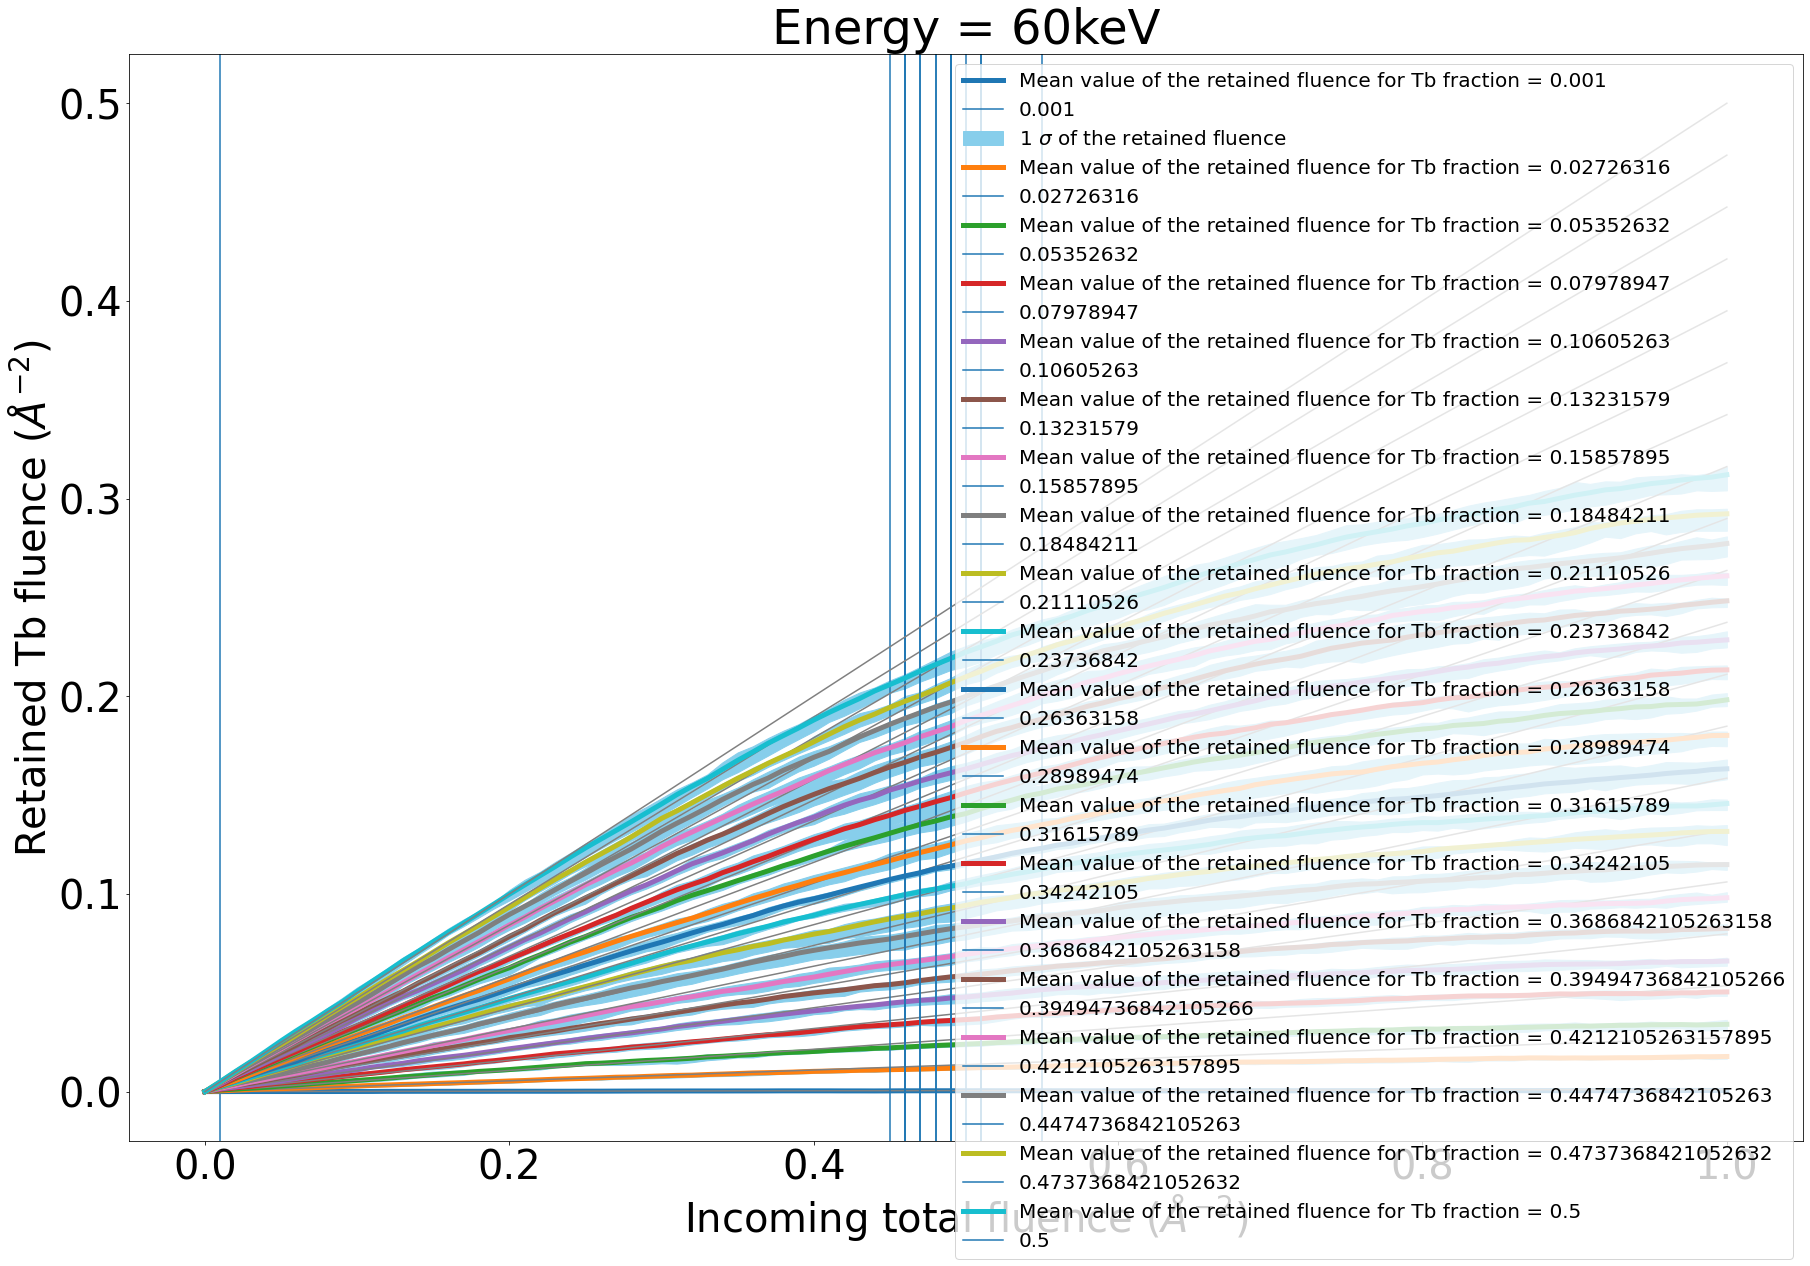

In [22]:
kleuren = ['blue','blue','blue','blue','orange','orange','orange','orange','green','green','green','green','red','red','red','red','purple','purple','c','c','black','black']
plt.rcParams.update({'font.size': 40})
plt.figure(figsize=(30, 20))
plt.tight_layout()
fractions = [0.001,0.02726316,0.05352632,0.07978947,0.10605263,0.13231579,0.15857895,0.18484211,0.21110526,0.23736842,0.26363158,0.28989474,0.31615789,0.34242105,0.3686842105263158,0.39494736842105266,0.4212105263157895,0.4474736842105263,0.4737368421052632,0.5]
counter = 0
allstarts = []
allups = []
alldowns = []
allstartstb = []
allupstb = []
alldownstb = []
for fraction in fractions:
    print(counter)
    if counter % 1 ==0:
        finalretfl = []
        finalretflup = []
        finalretfldown = []
        namenlijst = allnames[counter*10:counter*10+10]
        #print(namenlijst)
        retainedcurves=[]
        for nametje in namenlijst:
            name = nametje[0:len(nametje)-3]
            path = "C:/Users/r0750853/linux/TRIDYN/Simulated_data/Effect_of_fractionGd_Tb/"
            areal_dens = "Areal_density/" + name + "_ardn.dat"
            profiles = "Depth_profile/" + name + "/"
            A = TRIDYN_simulation(file_retained = path + areal_dens, file_profiles = path + profiles, aantalincomming = 2, fractions = [fraction,1-fraction],elementen=['Tb','Gd'])
            A.load()
            retainedcurves.append(np.array(A.retained_vals[0]))
        retainedcurves = np.array(retainedcurves) #consist of the retained curves for each of the 10 random numbers
        means = []
        stdevup = []
        stdevdown = []
        sigmapos = []
        influ = A.fluence_vals
        beginsputt=[]
        for ii in range(101):
            retwaarden = retainedcurves[:,ii]
            means.append(np.mean(retwaarden))
            gesort  = np.sort(retwaarden)
            #print(gesort)
            stdevdown.append(gesort[1])
            stdevup.append(gesort[7])
            sigmapos.append(np.std(retwaarden))
            if gesort[7] < influ[ii]*fraction:
                beginsputt.append(influ[ii])
        flst = []
        flstup = []
        flstdown = []
        for ii in range(len(means)):
            if 0.9*influ[ii]*fraction>means[ii]:
                flst.append(influ[ii])
            if 0.9*influ[ii]*fraction>means[ii]-(means[ii]-stdevdown[ii])/np.sqrt(10):
                flstdown.append(influ[ii])
            if 0.9*influ[ii]*fraction>means[ii]+(-means[ii]+stdevup[ii])/np.sqrt(10):
                flstup.append(influ[ii])
        beginsputttotfl = min(flst)
        allstarts.append(beginsputttotfl)
        allstartstb.append(beginsputttotfl*fraction)
        allups.append(min(flstup))
        alldowns.append(min(flstdown))
        allupstb.append(min(flstup)*fraction)
        alldownstb.append(min(flstdown)*fraction)
        print(flstdown)
        #if len(beginsputt)==0:
        #    beginsputt = influ[-1]
        #else:
        #    beginsputt = np.min(np.array(beginsputt))
        if counter==1:
            #plt.fill_between(influ*fraction,stdevdown,stdevup,color = 'skyblue',label='1 $\sigma$ of the retained fluence')
            plt.fill_between(influ,stdevdown,stdevup,color = 'skyblue',label='1 $\sigma$ of the retained fluence')
        else:
            #plt.fill_between(influ*fraction,stdevdown,stdevup,color = 'skyblue')
            plt.fill_between(influ,stdevdown,stdevup,color = 'skyblue')
        #plt.plot(influ*fraction,means,lw=5,label='Mean value of the retained fluence for Tb fraction = '+str(fraction))
        plt.plot(influ,means,lw=5,label='Mean value of the retained fluence for Tb fraction = '+str(fraction))
        #plt.plot(np.linspace(0,1*fraction,10),np.linspace(0,1*fraction,10),'gray')
        plt.plot(np.linspace(0,1,10),np.linspace(0,1,10)*fraction,'gray')
        plt.axvline(beginsputttotfl,label=str(fraction))
        plt.ylabel('Retained Tb fluence ($\AA^{-2}$)')
        plt.xlabel('Incoming total fluence ($\AA^{-2}$)')
        plt.title('Energy = 60keV')
        finalretfl.append(means[-1])
        finalretflup.append(stdevup[-1])
        finalretfldown.append(stdevdown[-1])
        #print('For fraction of Tb = ' +str(fraction)+ ' the retained fluence for an incoming fluence of 1, is ' + str(means[-1]) +' (up: ' + str(stdevup[-1])+ ', down: '+ str(stdevdown[-1]))
        deltar=0.000005#in mm
        retjes = np.array(np.arange(0,8,deltar))
        #incoming activity
        partinc = 1*(np.pi*((retjes+deltar)**2-(retjes)**2)*10**(14))
        totpartinc = np.sum(partinc)*fraction
        actinc = totpartinc*1.5*10**(-6)*10**(-6)
        #mean activity
        partret = finalretfl*(np.pi*((retjes+deltar)**2-(retjes)**2)*10**(14))
        totpartret = np.sum(partret)
        actcollected = totpartret*1.5*10**(-6)*10**(-6)
        #upact
        partretup = finalretflup*(np.pi*((retjes+deltar)**2-(retjes)**2)*10**(14))
        totpartup = np.sum(partretup)
        actup = totpartup*1.5*10**(-6)*10**(-6)
        #downact
        partretdown= finalretfldown*(np.pi*((retjes+deltar)**2-(retjes)**2)*10**(14))
        totpartdown = np.sum(partretdown)
        actdown = totpartdown*1.5*10**(-6)*10**(-6)
        #print('For fraction of Tb = ' +str(fraction)+ ' the retained activity for an incoming activity of '+str(actinc)+', is ' + str(actcollected) +' (up: ' + str(actup)+ ', down: '+ str(actdown))
    counter+=1
plt.rcParams.update({'font.size': 20})
plt.legend()
plt.rcParams.update({'font.size': 40})
#plt.xlim([0,0.10])
plt.savefig('C:/Users/r0750853/Documents/totflu.pdf', dpi=500,bbox_inches = 'tight',facecolor='white')

In [15]:
print(alldowns)
realflstdown = alldowns.copy()
realflstdown[6] = 0.4
realflstdown[13] = 0.45
print(realflstdown)

[0.01, 0.44, 0.47, 0.5, 0.49, 0.45, 0.02, 0.46, 0.45, 0.47, 0.46, 0.42, 0.48, 0.01, 0.48, 0.48, 0.47, 0.48, 0.47, 0.47]
[0.01, 0.44, 0.47, 0.5, 0.49, 0.45, 0.4, 0.46, 0.45, 0.47, 0.46, 0.42, 0.48, 0.45, 0.48, 0.48, 0.47, 0.48, 0.47, 0.47]


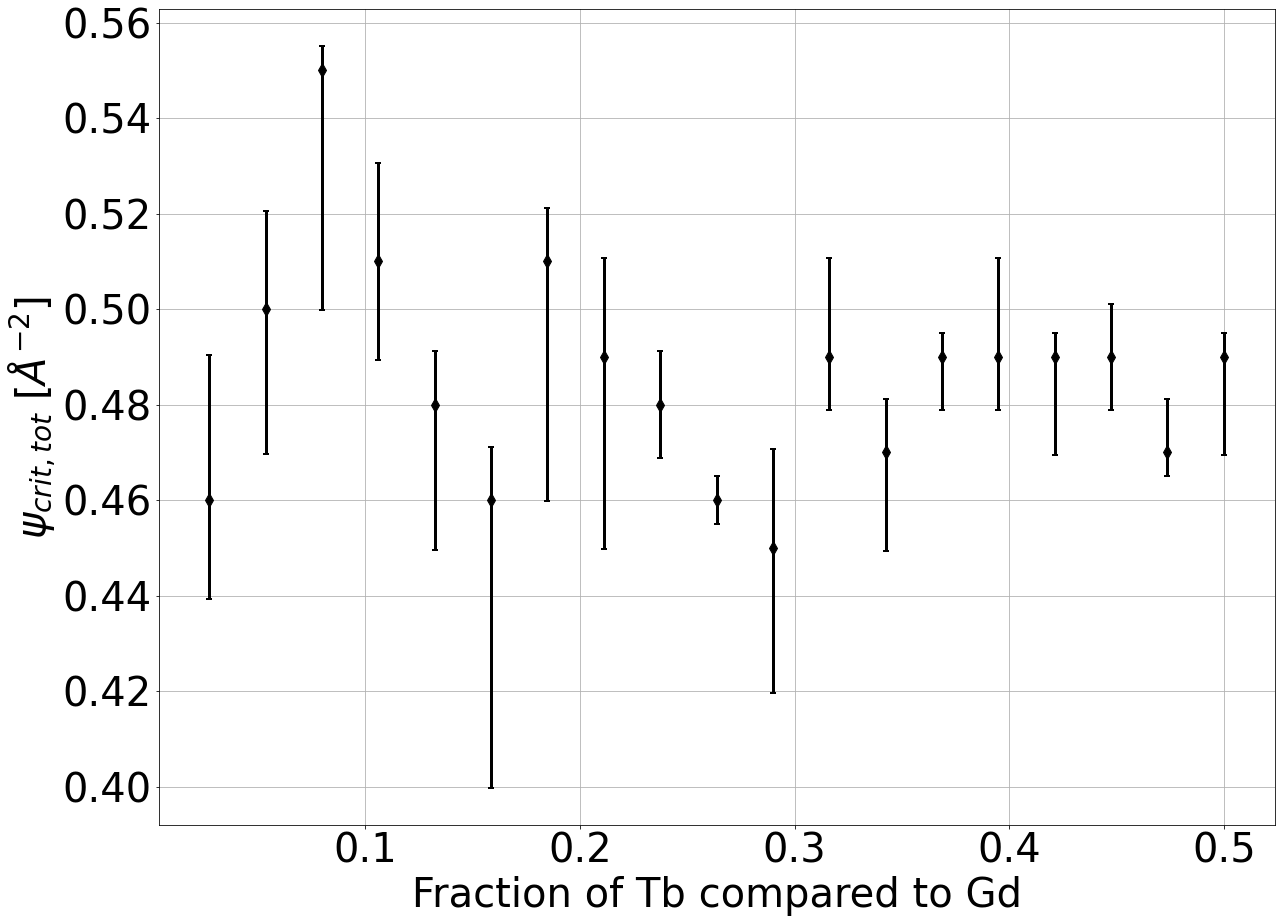

In [17]:
#plt.plot(fractions, allstarts) 
#plt.plot(fractions, alldowns) 
#plt.plot(fractions, allups) 
plt.rcParams['figure.figsize'] = [20, 15]

plt.rcParams.update({'font.size': 40}) 
plt.errorbar(fractions[1:100],allstarts[1:100],yerr = [np.sqrt(((np.array(allstarts)-np.array(realflstdown))[1:100])**2 + ((influ[1]-influ[0])/2)**2),np.sqrt(((np.array(allups)-np.array(allstarts))[1:100])**2 + ((influ[1]-influ[0])/2)**2)], markersize=10, fmt="d", color="k",
             ecolor="k", capsize=3, capthick=2, linewidth=3)
plt.xlabel('Fraction of Tb compared to Gd')
plt.ylabel('$\psi_{crit, tot}$ [$\AA^{-2}$]')
plt.grid()
#plt.savefig('C:/Users/r0750853/Documents/effectofGdenTbtotflu.pdf', dpi=500,bbox_inches = 'tight',facecolor='white')


In [24]:
print(alldownstb)
realflstdowntb = alldownstb.copy()
realflstdowntb[6] = 0.4*fractions[6]
realflstdowntb[13] = 0.45*fractions[13]
print(realflstdowntb)

[1e-05, 0.011995790400000001, 0.0251573704, 0.039894735, 0.051965788699999994, 0.0595421055, 0.003171579, 0.0850273706, 0.094997367, 0.11156315739999999, 0.1212705268, 0.12175579079999999, 0.1517557872, 0.0034242105, 0.17696842105263158, 0.18957473684210527, 0.19796894736842105, 0.21478736842105262, 0.22265631578947367, 0.235]
[1e-05, 0.011995790400000001, 0.0251573704, 0.039894735, 0.051965788699999994, 0.0595421055, 0.06343158, 0.0850273706, 0.094997367, 0.11156315739999999, 0.1212705268, 0.12175579079999999, 0.1517557872, 0.15408947250000002, 0.17696842105263158, 0.18957473684210527, 0.19796894736842105, 0.21478736842105262, 0.22265631578947367, 0.235]


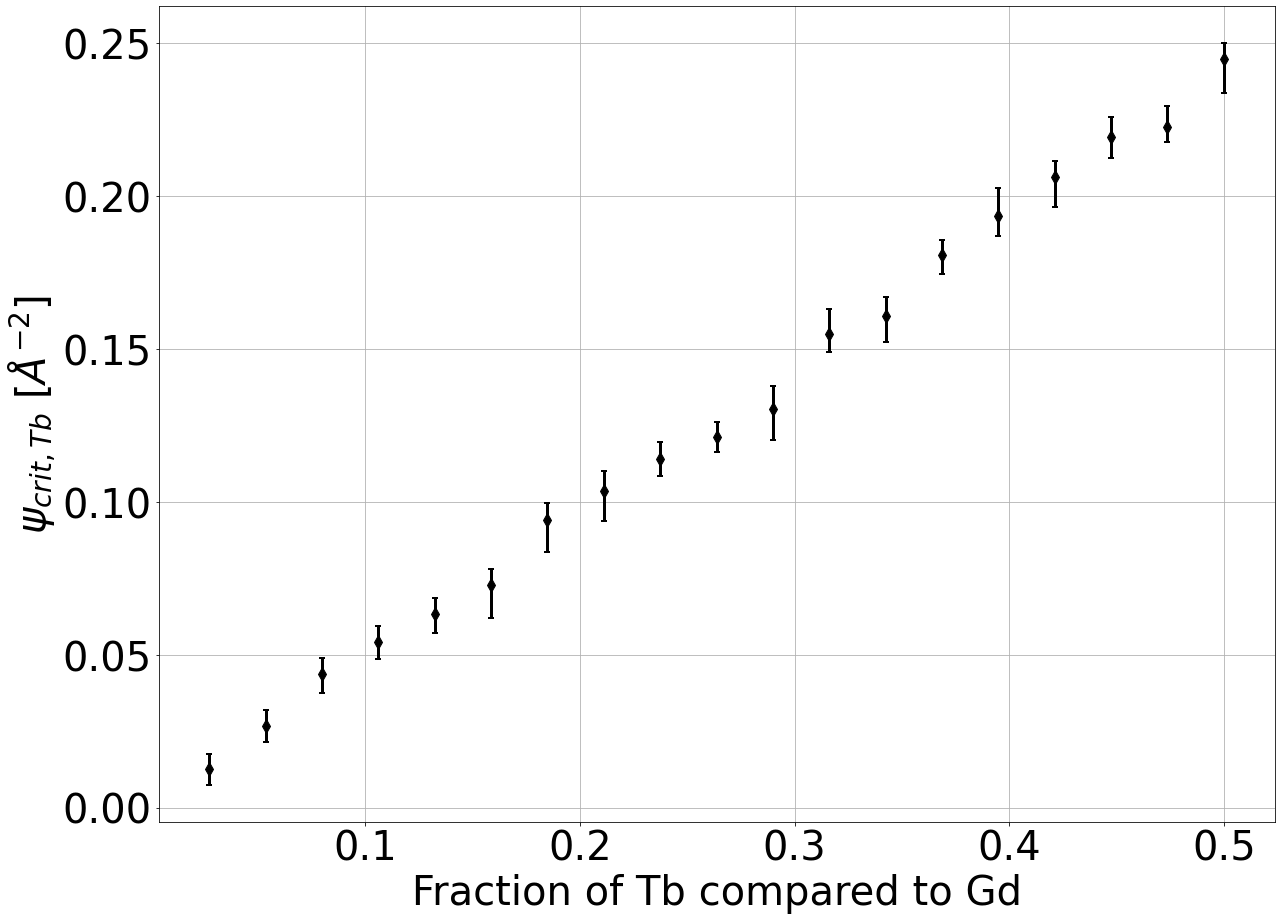

In [26]:
#plt.plot(fractions, allstarts) 
#plt.plot(fractions, alldowns) 
#plt.plot(fractions, allups) 
plt.rcParams['figure.figsize'] = [20, 15]

plt.rcParams.update({'font.size': 40}) 
plt.errorbar(fractions[1:100],allstartstb[1:100],yerr = [np.sqrt(((np.array(allstartstb)-np.array(realflstdowntb))[1:100])**2 + ((influ[1]-influ[0])/2)**2),np.sqrt(((np.array(allupstb)-np.array(allstartstb))[1:100])**2 + ((influ[1]-influ[0])/2)**2)], markersize=10, fmt="d", color="k",
             ecolor="k", capsize=3, capthick=2, linewidth=3)
plt.xlabel('Fraction of Tb compared to Gd')
plt.ylabel('$\psi_{crit, Tb}$ [$\AA^{-2}$]')
plt.grid()
#plt.savefig('C:/Users/r0750853/Documents/effectofGdenTbtotflu.pdf', dpi=500,bbox_inches = 'tight',facecolor='white')
